In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt 
from PIL import Image 
import numpy as np 
import os 
import cv2 
from tqdm import tqdm_notebook 
from random import shuffle 
import shutil 
import pandas as pd 

In [2]:
def organize_datasets(path_to_data, n=4000, ratio=0.2):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

In [3]:
ratio = 0.2
n = 25000
organize_datasets(path_to_data='./train/', n=n, ratio=ratio)

/data/ removed
folders created !



Data copied!


In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

Using TensorFlow backend.


In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
        './data/train/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        './data/validation/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

##Found 20000 images belonging to 2 classes.
##Found 5000 images belonging to 2 classes.

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________

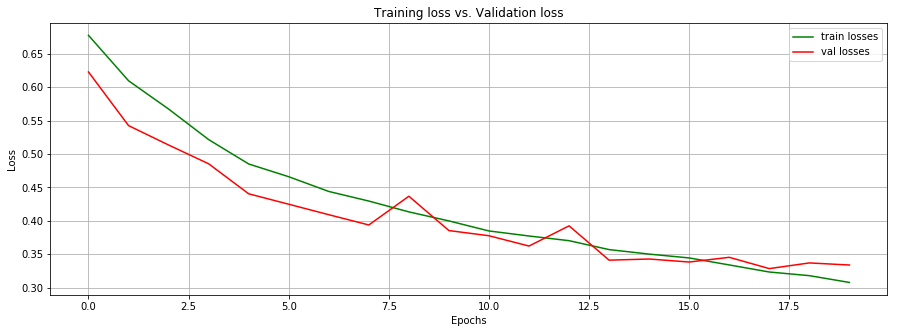

In [6]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(n * (1-ratio)) // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= int(n * ratio) // batch_size,
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],
        verbose=0)

model.save('./models/model4.h5')

losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

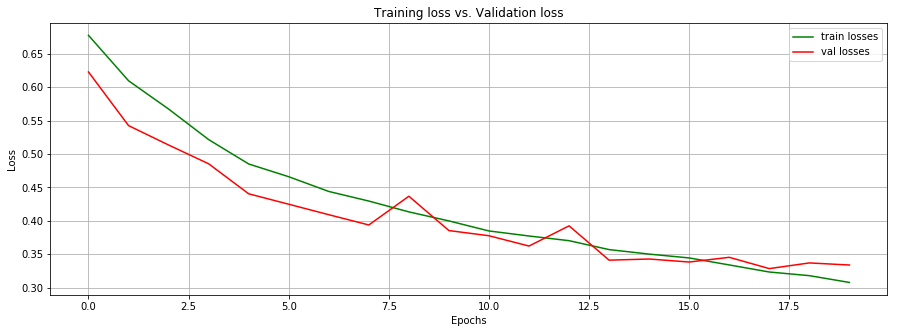

In [7]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [8]:
model.save('./model4.h5')

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
print("step1")
from keras import applications
# include_top: whether to include the 3 fully-connected layers at the top of the network.
model = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255)
print("step2")
generator = datagen.flow_from_directory('./data/train/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)
print("stape3")
bottleneck_features_train = model.predict_generator(generator, int(n * (1 - ratio)) // batch_size)
np.save(open('./features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
print("finished")
##Found 20000 images belonging to 2 classes.
generator = datagen.flow_from_directory('./data/validation/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, int(n * ratio) // batch_size,)
np.save('./features/bottleneck_features_validation.npy', bottleneck_features_validation)

##Found 5000 images belonging to 2 classes.

train_data = np.load('./features/bottleneck_features_train.npy')
train_labels = np.array([0] * (int((1-ratio) * n) // 2) + [1] * (int((1 - ratio) * n) // 2))

validation_data = np.load('./features/bottleneck_features_validation.npy')
validation_labels = np.array([0] * (int(ratio * n) // 2) + [1] * (int(ratio * n) // 2))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

fitted_model = model.fit(train_data, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels[:validation_data.shape[0]]),
          verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=False), history])

fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()          

fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation sete")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

step1
step2
Found 20000 images belonging to 2 classes.
stape3
